In this section we will take a look at Gaussian mixture models, which can be viewed as an extension of k-means, but can also be a powerful tool for estimation beyond simple clustering.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Motivating GMM: Weakness of k-Means

In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X,y_true = make_blobs(n_samples=400,centers=4,
                     cluster_std=0.60,random_state=0)
X = X[:,::-1] #flip axes for better plotting

/Users/yuanyuhang/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


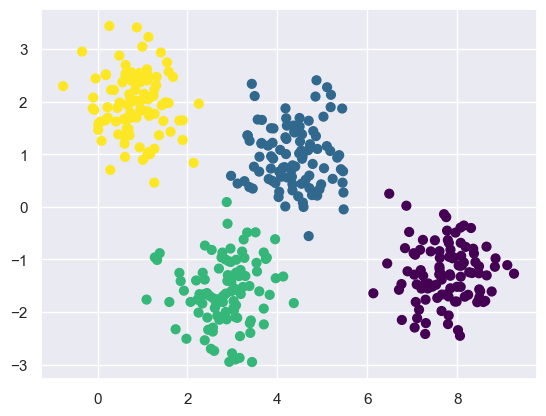

In [3]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4,random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=40,cmap='viridis')

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster. We can visualize this cluster model with the following function:

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans,X,n_clusters=4,rseed=0,ax=None):
    labels = kmeans.fit_predict(X)
    
    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:,0],X[:,1],c=labels,s=40,cmap='viridis',zorder=2)
    
    # plot the representation of the k-means model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i],[center]).max()
            for i,center in enumerate(centers)]
    for c,r in zip(centers, radii):
        ax.add_patch(plt.Circle(c,r,fc='#CCCCCC',lw=3,alpha=0.5,zorder=1))

/Users/yuanyuhang/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


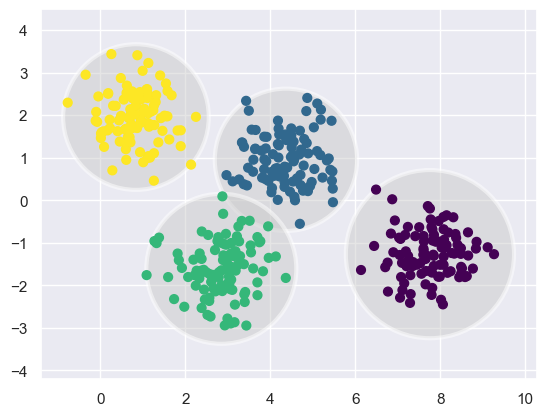

In [5]:
kmeans = KMeans(n_clusters=4,random_state=0)
plot_kmeans(kmeans,X)

An important observation for k-means is that these cluster models must be circular. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled.

/Users/yuanyuhang/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


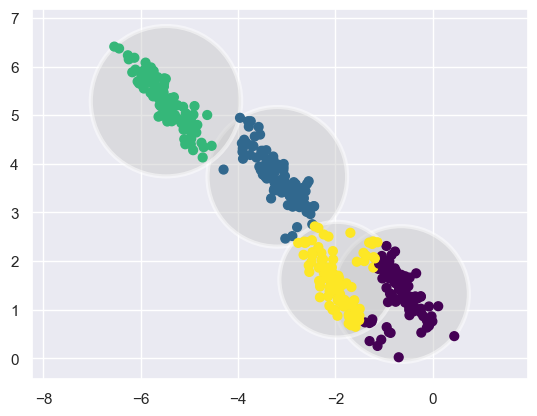

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X,rng.randn(2,2))

kmeans = KMeans(n_clusters=4,random_state=0)
plot_kmeans(kmeans,X_stretched)

Two disadvantages of k-means——its lack of flexibility in cluster shape and lack of probabilistic cluster assignment——mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

# Generalizing E-M: Gaussian Mixture Models

A Gaussian Mixture Model attenpts to find a mixture of multidimensional Gaussian prabability distribution that best model any input datasets. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

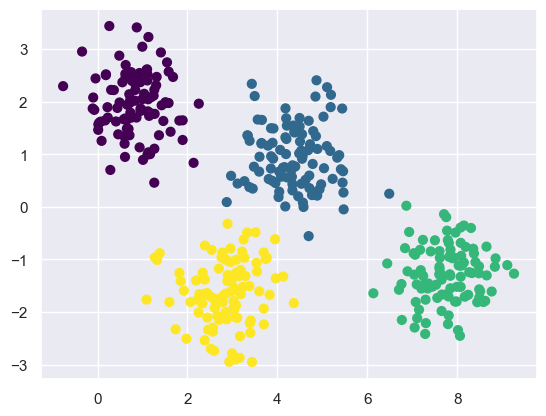

In [7]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:,0],X[:,1],c=labels,s=40,cmap='viridis')

Because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments——in Scikit-Learn we do this using the predict_proba method. This returns a matrix of size [n_samples n_clusters].

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.531 0.469 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    1.    0.    0.   ]
 [0.    0.    0.    1.   ]]


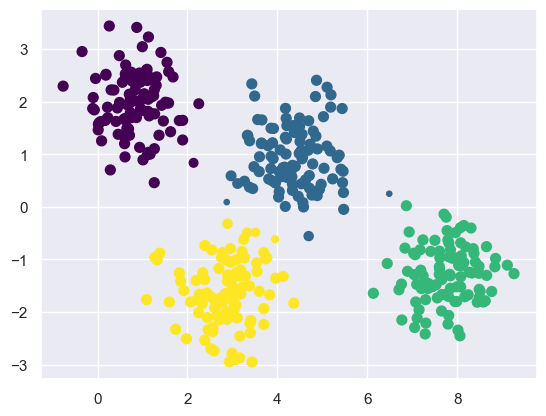

In [9]:
size = 50 * probs.max(1)**2 # square emphasizes differences
plt.scatter(X[:,0],X[:,1],c=labels,cmap='viridis',s=size)

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the gmm output:

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position,covariance,ax=None,**kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2,2):
        U,s,Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1,0],U[0,0]))
        width,height = 2 * np.sqrt(s)
    else:
        angle = 0
        width,height = 2 * np.sqrt(s)
        
    # Draw the ellipse
    for nsig in range(1,4):
        ax.add_patch(Ellipse(position,nsig * width,nsig * height,
                            angle, **kwargs))
        
def plot_gmm(gmm,X,label=True,ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:,0],X[:,1],c=labels,s=40,cmap='viridis',zorder=2)
    else:
        ax.scatter(X[:,0],X[:,1],s=40,zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos,covar,w in zip(gmm.means_,gmm.covariances_,gmm.weights_):
        draw_ellipse(pos,covar,alpha=w * w_factor)

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_945/3274423489.py:17: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position,nsig * width,nsig * height,


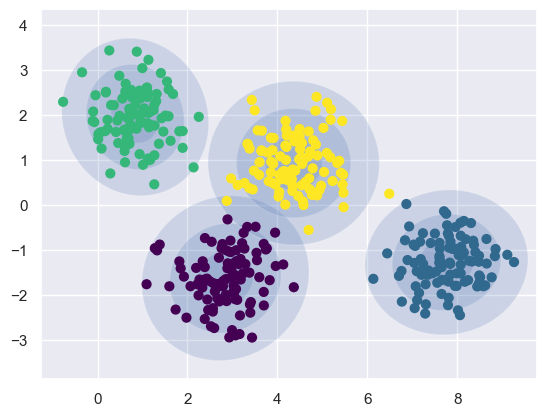

In [19]:
gmm = GMM(n_components=4,random_state=42)
plot_gmm(gmm,X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance.

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_945/3274423489.py:17: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position,nsig * width,nsig * height,


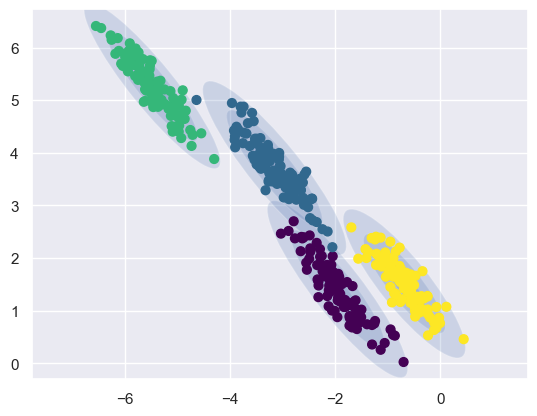

In [20]:
gmm = GMM(n_components=4,covariance_type='full',random_state=42) # covariance_type = 'diag'/'spherical'/'full'
plot_gmm(gmm,X_stretched)

# GMM as Density Estimation

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation.

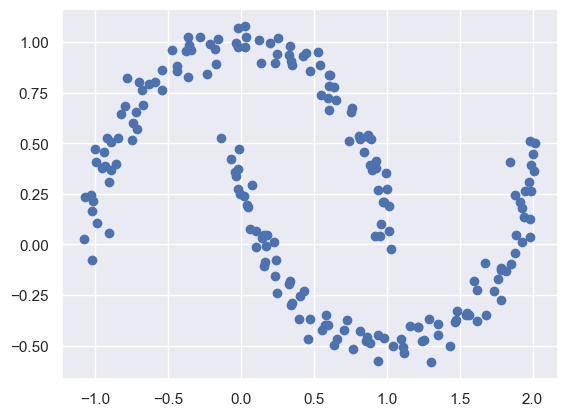

In [22]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200,noise=.05,random_state=0)
plt.scatter(Xmoon[:,0],Xmoon[:,1])

If we try to fit this to a two-component GMM viewed as a clustering model, the results are not particularly useful:

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_945/3274423489.py:17: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position,nsig * width,nsig * height,


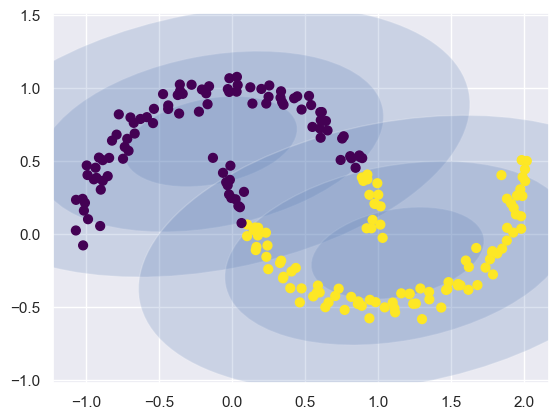

In [23]:
gmm2 = GMM(n_components=2,covariance_type='full',random_state=0)
plot_gmm(gmm2,Xmoon)

But if we instead use many more components and ignore the cluster labels, we find fit that is much closer to the input data:

/var/folders/7k/578pqnvd7t9_87g17msvh4100000gn/T/ipykernel_945/3274423489.py:17: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position,nsig * width,nsig * height,


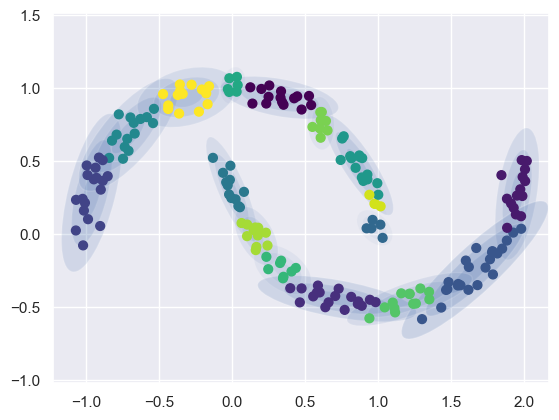

In [24]:
gmm16 = GMM(n_components=16,covariance_type='full',random_state=0)
plot_gmm(gmm16,Xmoon)

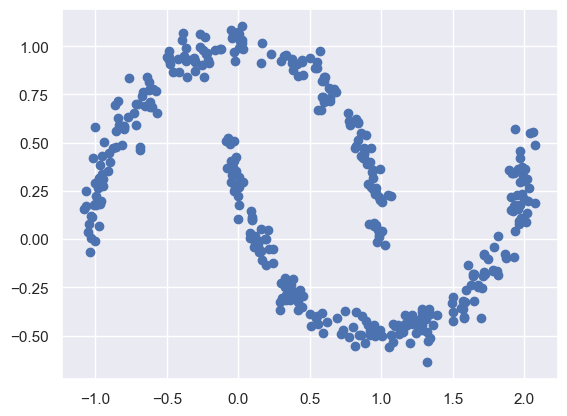

In [34]:
# Here are 400 new points drawn from this 16-component GMM fit to our original data
Xnew = gmm16.sample(400)
plt.scatter(Xnew[0][:,0],Xnew[0][:,1])

# How many components?

Let's look at the Akaike information criterion (AIC) and Bayesian information criterion (BIC) as a function as the number of GMM components for our moon dataset:

Text(0.5, 0, 'n_components')

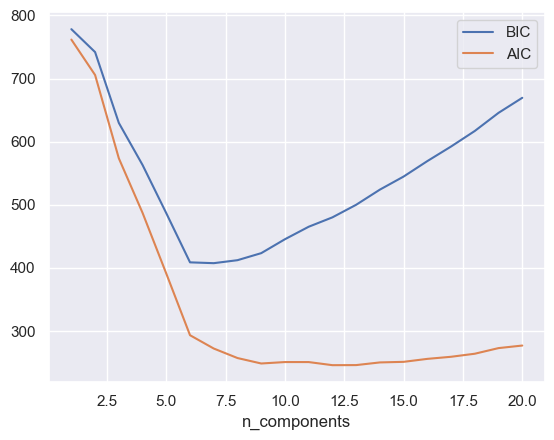

In [35]:
n_components = np.arange(1,21)
models = [GMM(n,covariance_type='full',random_state=0).fit(Xmoon)
         for n in n_components]
plt.plot(n_components,[m.bic(Xmoon) for m in models],label='BIC')
plt.plot(n_components,[m.aic(Xmoon) for m in models],label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approxamation we wish to use. The AIC tells us that our choice of 16 components was probably too many: around 8-12 components would have been a better choice.